In [1]:
!pip install kaggle

# Upload kaggle.json file (API key)
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip cifake-real-and-ai-generated-synthetic-images.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  inflating:

In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import time
import os

In [19]:
# Load data
train_data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder('train', transform=train_data_transform)
test_data = datasets.ImageFolder('test', transform=test_data_transform)

# Split train data into 80% train / 20% validation
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

for images, labels in train_loader:
  print("Image batch shape:", images.shape)
  print("Label batch shape:", labels.shape)
  break


Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])


In [20]:
# Print the number of samples in the train and test sets
print('Number of training samples:', len(train_data))
print('Number of validation samples:', len(val_data))
print('Number of testing samples:', len(test_data))


Number of training samples: 80000
Number of validation samples: 20000
Number of testing samples: 20000


In [21]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(f"Using device {device} for training.")
print("Model initialized.")


Using device cuda:0 for training.
Model initialized.


In [22]:
# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Training loop
epoch_train_losses = []
epoch_train_accuracies = []
epoch_val_losses = []
epoch_val_accuracies = []
start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs} training...")
    epoch_start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    epoch_train_losses.append(train_loss / len(train_data))
    epoch_train_accuracies.append(100 * train_correct / len(train_data))


    # Validation
    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()

    epoch_val_losses.append(val_loss / len(val_data))
    epoch_val_accuracies.append(100 * val_correct / len(val_data))

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_train_losses[-1]:.4f}, Train Acc: {epoch_train_accuracies[-1]:.2f}%, Val Loss: {epoch_val_losses[-1]:.4f}, Val Acc: {epoch_val_accuracies[-1]:.2f}%, Time: {epoch_time:.2f}s")

end_time = time.time()
total_time = end_time - start_time
print(f"Training finished. Total time: {total_time:.2f}s")

# Save model checkpoint
ckpt_dir = "model_checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
timestamp = time.strftime("%Y%m%d_%H%M%S", time.localtime())
filename = f"{timestamp}_valacc_{epoch_val_accuracies[-1]:.2f}.pt"
filepath = os.path.join(ckpt_dir, filename)
torch.save(model.state_dict(), filepath)
print(f"Saved checkpoint: {filepath}")


Epoch 1/10 training...
Epoch 1/10 - Train Loss: 0.3115, Train Acc: 86.13%, Val Loss: 0.2248, Val Acc: 90.94%, Time: 55.02s
Epoch 2/10 training...
Epoch 2/10 - Train Loss: 0.1963, Train Acc: 92.22%, Val Loss: 0.1728, Val Acc: 93.33%, Time: 54.67s
Epoch 3/10 training...
Epoch 3/10 - Train Loss: 0.1705, Train Acc: 93.35%, Val Loss: 0.1610, Val Acc: 93.82%, Time: 54.72s
Epoch 4/10 training...
Epoch 4/10 - Train Loss: 0.1569, Train Acc: 93.90%, Val Loss: 0.1459, Val Acc: 94.38%, Time: 54.71s
Epoch 5/10 training...
Epoch 5/10 - Train Loss: 0.1448, Train Acc: 94.32%, Val Loss: 0.1447, Val Acc: 94.36%, Time: 54.63s
Epoch 6/10 training...
Epoch 6/10 - Train Loss: 0.1377, Train Acc: 94.65%, Val Loss: 0.1505, Val Acc: 94.28%, Time: 54.79s
Epoch 7/10 training...
Epoch 7/10 - Train Loss: 0.1297, Train Acc: 94.95%, Val Loss: 0.1406, Val Acc: 94.59%, Time: 54.58s
Epoch 8/10 training...
Epoch 8/10 - Train Loss: 0.1216, Train Acc: 95.26%, Val Loss: 0.1376, Val Acc: 94.83%, Time: 54.56s
Epoch 9/10 train

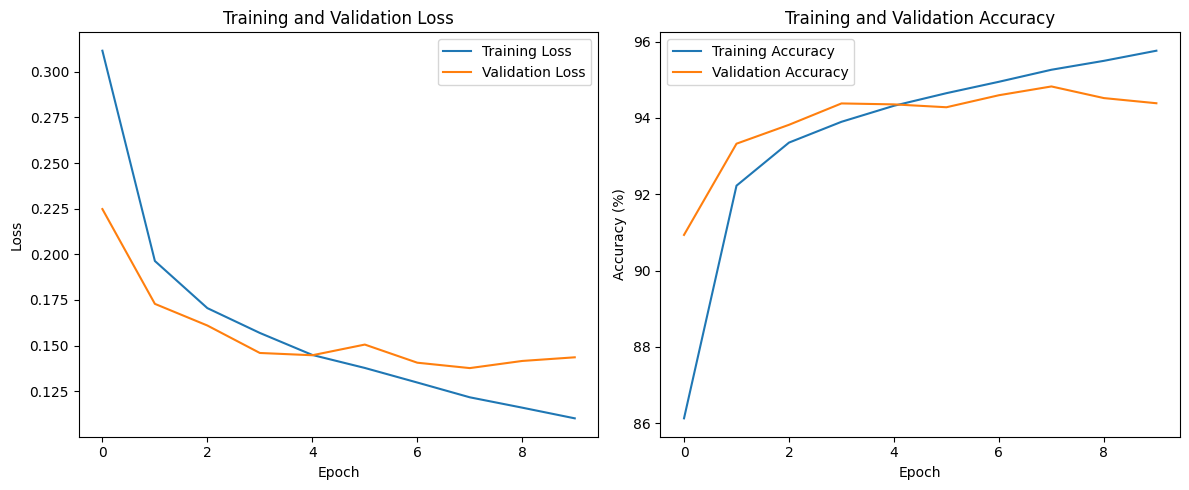

In [25]:
# Plot training and validation losses and accuracies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_accuracies, label='Training Accuracy')
plt.plot(epoch_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Optional: load model from checkpoint
ckpt_dir = "model_checkpoints"
ckpt_name = "CHECKPOINT NAME HERE"

checkpoint_path = os.path.join(ckpt_dir, ckpt_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

In [28]:
# Evaluate model on test data
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')

Accuracy of the network on the test images: 94.08 %
